<a href="https://colab.research.google.com/github/uldkh/colab_projects/blob/main/2_NLP_SNN%2C_Embedding%2C_CNN%2C_Dence_Regression_on_hh_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Embedding, Conv1D, GlobalMaxPooling1D, MaxPool1D
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import keras.backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import random 
import re
import gc
import time
import datetime
import sys, traceback, gc
from IPython.display import clear_output

In [ ]:
def set_plt_params():
  
  plt.rc("axes", facecolor="#181c27", edgecolor="#2a2e39", grid=True)
  plt.rc("figure", figsize=(17.87, 10.45), facecolor="#181c27", edgecolor="#2a2e39")
  plt.rc("grid", color="#2a2e39", linestyle="dashed")
  plt.rc("xtick", labelsize=11, color="#b2b5be", bottom=False)
  plt.rc("ytick", labelsize=11, color="#b2b5be", left=False)
  plt.rc("legend", handleheight=1, handlelength=2)
  plt.rc("text", color="#b2b5be")

set_plt_params()

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
hh_df = pd.read_csv("/content/drive/My Drive/DataBases/hh_fixed.csv")

In [ ]:
hh_df.head()

,Unnamed: 0,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано
3,3,"Мужчина , 33 года , родился 2 августа 1985",180000 руб.,Руководитель IT отдела,"Москва , м. Щукинская , не готов к переезду ,...","частичная занятость, полная занятость","удаленная работа, полный день",Опыт работы 15 лет 10 месяцев Руководитель IT...,"""Ай-Теко"", ведущий российский системный интегр...",Старший системный администратор,Руководитель IT отдела 180 000 руб. Информацио...,09.04.2019 14:39,Имеется собственный автомобиль
4,4,"Мужчина , 22 года , родился 1 сентября 1996",40000 руб.,Junior Developer,"Москва , м. Юго-Западная , не готов к переезд...","стажировка, частичная занятость, проектная работа","гибкий график, удаленная работа",Опыт работы 1 год 1 месяц Junior Developer 40...,R-Style SoftLab,Менеджер IT-проектов,Junior Developer 40 000 руб. Информационные те...,29.03.2019 12:40,Не указано


In [ ]:
hh_df.drop(hh_df.columns[0], axis=1, inplace=True)
hh_df.head()

,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано
3,"Мужчина , 33 года , родился 2 августа 1985",180000 руб.,Руководитель IT отдела,"Москва , м. Щукинская , не готов к переезду ,...","частичная занятость, полная занятость","удаленная работа, полный день",Опыт работы 15 лет 10 месяцев Руководитель IT...,"""Ай-Теко"", ведущий российский системный интегр...",Старший системный администратор,Руководитель IT отдела 180 000 руб. Информацио...,09.04.2019 14:39,Имеется собственный автомобиль
4,"Мужчина , 22 года , родился 1 сентября 1996",40000 руб.,Junior Developer,"Москва , м. Юго-Западная , не готов к переезд...","стажировка, частичная занятость, проектная работа","гибкий график, удаленная работа",Опыт работы 1 год 1 месяц Junior Developer 40...,R-Style SoftLab,Менеджер IT-проектов,Junior Developer 40 000 руб. Информационные те...,29.03.2019 12:40,Не указано


In [ ]:
hh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62967 entries, 0 to 62966
Data columns (total 12 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Пол, возраст                              62967 non-null  object
 1   ЗП                                        62967 non-null  object
 2   Ищет работу на должность:                 62967 non-null  object
 3   Город                                     62967 non-null  object
 4   Занятость                                 62967 non-null  object
 5   График                                    62967 non-null  object
 6   Опыт (двойное нажатие для полной версии)  62599 non-null  object
 7   Последенее/нынешнее место работы          62965 non-null  object
 8   Последеняя/нынешняя должность             62963 non-null  object
 9   Образование и ВУЗ                         62967 non-null  object
 10  Обновление резюме                         6296

In [ ]:
hh_df.isna().sum()

Пол, возраст                                  0
ЗП                                            0
Ищет работу на должность:                     0
Город                                         0
Занятость                                     0
График                                        0
Опыт (двойное нажатие для полной версии)    368
Последенее/нынешнее место работы              2
Последеняя/нынешняя должность                 4
Образование и ВУЗ                             0
Обновление резюме                             0
Авто                                          0
dtype: int64

In [ ]:
hh_df.describe(include="object")

,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
count,62967,62967,62967,62967,62967,62967,62599,62965,62963,62967,62967,62967
unique,16750,743,16361,10495,38,47,48506,32408,18182,42806,21235,2
top,"Мужчина , 29 лет , родился 18 октября 1989",50000 руб.,Системный администратор,"Москва , не готов к переезду , не готов к кома...",полная занятость,полный день,Опыт работы 5 лет 7 месяцев Октябрь 2016 — по...,Индивидуальное предпринимательство / частная п...,Системный администратор,Образование Среднее образование,07.05.2019 09:50,Не указано
freq,24,5780,4280,2038,42276,32052,4,1362,2848,1856,25,45794


In [ ]:
hh_df = hh_df.apply(lambda x: x.replace("\xa0","").replace("\n"," ") if type(x) == str else x)

# Зарплата

In [ ]:
hh_df["ЗП"].apply(lambda x: x.isdigit()).sum()

0

In [ ]:
currencies = hh_df["ЗП"].apply(lambda x: re.sub("[0-9]","", x)).value_counts().index
currencies

Index([' руб.', ' KZT', ' USD', ' бел.руб.', ' EUR', ' грн.', ' сум', ' KGS',
       ' AZN'],
      dtype='object')

In [ ]:
rate = [1, 0.17, 74, 29.11, 83.13, 2.73, 0.0068, 0.87, 43.21]
len(currencies) == len(rate)

True

In [ ]:
for i in range(len(currencies)):
  hh_df["ЗП"] = hh_df["ЗП"].apply(lambda x: x if (type(x) == int) | (type(x) == float) else (int(re.sub('[а-яА-ЯёЁ.a-zA-Z]','', x)) * rate[i] if currencies[i] in x else x))

In [ ]:
hh_df["ЗП"].apply(lambda x: True if type(x) == str else False).sum()

0

In [ ]:
hh_df["ЗП"].dtypes

dtype('float64')

In [ ]:
hh_df["ЗП"] = hh_df["ЗП"].transform(lambda x: round(x / 1000, 2))

In [ ]:
hh_df.rename({"ЗП" : "зп_тыс_руб"}, axis=1, inplace=True)

In [ ]:
hh_df.describe()

,зп_тыс_руб
count,62967.000000
mean,77.503528
std,135.233349
min,0.000000
25%,35.000000
50%,55.000000
75%,95.000000
max,28120.000000


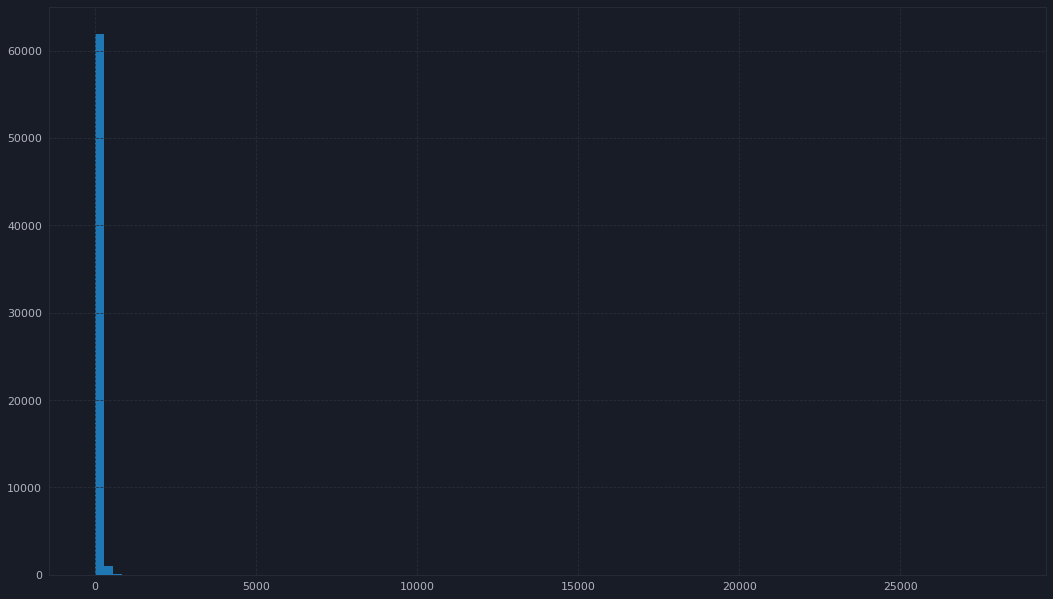

In [ ]:
hh_df["зп_тыс_руб"].hist(bins=100)
plt.show()

In [ ]:
hh_df[hh_df["зп_тыс_руб"] > hh_df["зп_тыс_руб"].quantile(0.99)].count()

Пол, возраст                                550
зп_тыс_руб                                  550
Ищет работу на должность:                   550
Город                                       550
Занятость                                   550
График                                      550
Опыт (двойное нажатие для полной версии)    550
Последенее/нынешнее место работы            550
Последеняя/нынешняя должность               550
Образование и ВУЗ                           550
Обновление резюме                           550
Авто                                        550
dtype: int64

In [ ]:
 hh_df[hh_df["зп_тыс_руб"] > 1000]

,"Пол, возраст",зп_тыс_руб,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
10707,"Мужчина , 29 лет , родился 21 апреля 1990",8880.0,Специалист по IT,"Актобе , готов к переезду , готов к командировкам",полная занятость,полный день,Опыт работы 8 лет 2 месяца Специалист по IT 1...,"ТОО ""AMS""",Системный администратор,Среднее специальное образование 2009 Экономика...,22.04.2019 15:21,Не указано
14818,"Мужчина , 38 лет , родился 10 февраля 1981",2500.0,Chief AI Officer,"Москва , не готов к переезду , не готов к кома...",полная занятость,полный день,Опыт работы 8 лет 1 месяц Chief AI Officer 2 ...,Finnish Russian Univeristy Cooperation in Tele...,Project Manager in Multimedia Technologies,Высшее образование (Кандидат наук) 2006 Postgr...,25.10.2018 02:49,Не указано
18570,"Мужчина , 46 лет , родился 13 февраля 1973",2000.0,"BizTalk, SQL, SharePoint. Системный архитектор...","Москва , готов к переезду , готов к командировкам",полная занятость,полный день,"Опыт работы 21 год 4 месяца BizTalk, SQL, Sha...","Мэйджор Карго Сервис (прежде в РЖДстрой, Luxof...",разработчик ПО / системный архитектор,"BizTalk, SQL, SharePoint. Системный архитектор...",10.04.2019 16:28,Не указано
21074,"Мужчина , 24 года , родился 27 декабря 1994",1750.0,Project manager,"Москва , м. Киевская , не готов к переезду , ...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы 3 года 3 месяца Project manager 1...,Тинькофф Банк,Технолог автоматизации бизнес-процессов,Неоконченное высшее образование 2020 Московск...,22.04.2019 18:48,Не указано
21694,"Мужчина , 39 лет , родился 31 мая 1979",3000.0,"Руководитель IT проектов, Роботизация, Автомат...","Москва , м. Щелковская , готов к переезду (Бе...","частичная занятость, проектная работа, полная ...","гибкий график, полный день, вахтовый метод, уд...",Опыт работы 23 года 4 месяца Руководитель IT ...,HAMSTER ROBOTICS,Заместитель директора,Высшее образование 2019 Московский финансово-...,27.04.2019 09:41,Имеется собственный автомобиль
32821,"Мужчина , 36 лет , родился 2 июня 1982",2000.0,IT архитектор,"Москва , готов к переезду (Москва) , не готов ...",полная занятость,полный день,Опыт работы 13 лет 7 месяцев IT архитектор 2 ...,Credit Suisse,Head of Fixed Income IT support,IT архитектор 2 000 000 руб. Информационные те...,13.01.2019 19:41,Не указано
37362,"Мужчина , 31 год , родился 31 мая 1987",28120.0,"Программирование, Разработка или Системный адм...","Алматы , готов к переезду (Россия, Казахстан, ...","частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, уд...","Опыт работы 9 лет 7 месяцев Программирование,...","Евразийский банк, АО",Главный специалист Отдел разработки систем роз...,"Высшее образование 2014 Университет «Туран», ...",22.04.2019 14:09,Не указано
46810,"Мужчина , 31 год , родился 26 ноября 1987",2911.0,PPC Manager / Специалист по контекстной рекламе,"Минск , не готов к переезду , не готов к коман...",полная занятость,полный день,Опыт работы 8 лет 3 месяца PPC Manager / Спец...,ЧУП АйТиФикс,Директор,Образование Среднее образование,22.04.2019 08:31,Не указано


In [ ]:
indexes_to_drop = hh_df[hh_df["зп_тыс_руб"] > 1000].index

In [ ]:
hh_df.drop(indexes_to_drop, inplace=True)

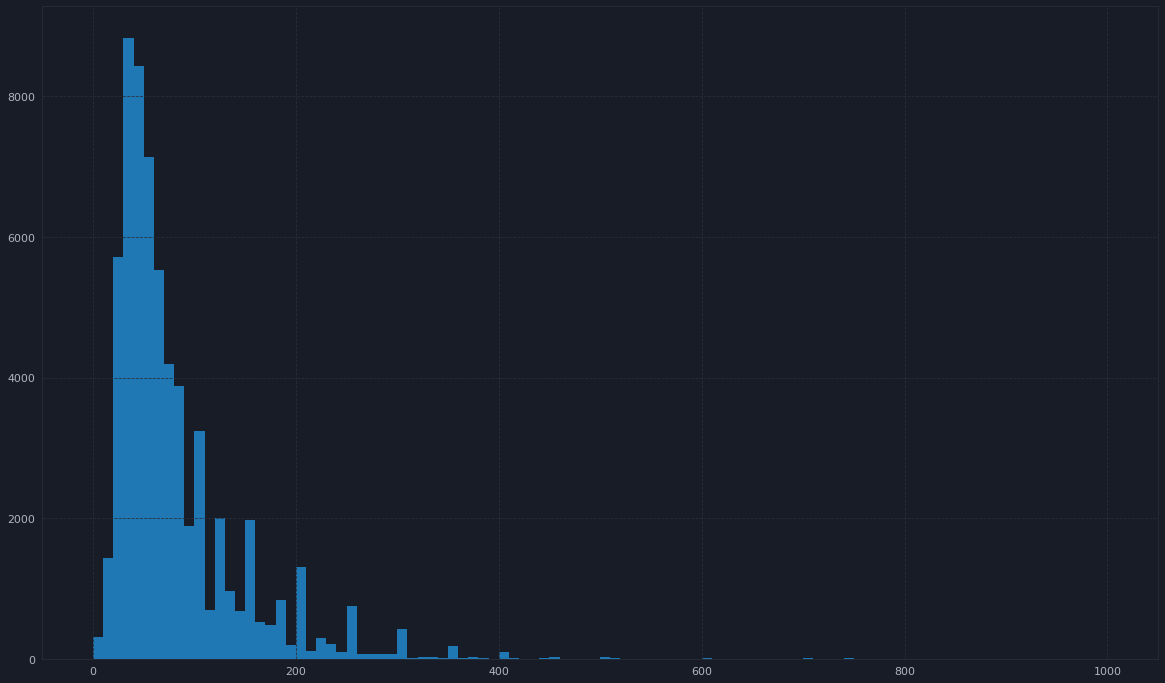

In [ ]:
plt.figure(figsize=(20, 12))
hh_df["зп_тыс_руб"].hist(bins=100)

In [ ]:
hh_df[hh_df["зп_тыс_руб"] < 1].count()[0]

123

In [ ]:
indexes_to_drop = hh_df[hh_df["зп_тыс_руб"] < 1].index
hh_df.drop(indexes_to_drop, inplace=True)

In [ ]:
hh_df.head()

,"Пол, возраст",зп_тыс_руб,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,"Мужчина , 29 лет , родился 16 мая 1989",40.0,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,"Мужчина , 38 лет , родился 25 мая 1980",40.0,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,"Мужчина , 35 лет , родился 14 июня 1983",300.0,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано
3,"Мужчина , 33 года , родился 2 августа 1985",180.0,Руководитель IT отдела,"Москва , м. Щукинская , не готов к переезду ,...","частичная занятость, полная занятость","удаленная работа, полный день",Опыт работы 15 лет 10 месяцев Руководитель IT...,"""Ай-Теко"", ведущий российский системный интегр...",Старший системный администратор,Руководитель IT отдела 180 000 руб. Информацио...,09.04.2019 14:39,Имеется собственный автомобиль
4,"Мужчина , 22 года , родился 1 сентября 1996",40.0,Junior Developer,"Москва , м. Юго-Западная , не готов к переезд...","стажировка, частичная занятость, проектная работа","гибкий график, удаленная работа",Опыт работы 1 год 1 месяц Junior Developer 40...,R-Style SoftLab,Менеджер IT-проектов,Junior Developer 40 000 руб. Информационные те...,29.03.2019 12:40,Не указано


# Последнее/нынешнее место работы, должность

In [ ]:
hh_df[hh_df["Последенее/нынешнее место работы"].isna()]

,"Пол, возраст",зп_тыс_руб,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
18143,"Женщина , 22 года , родилась 5 сентября 1996",10.0,Программист-стажер,"Дубна , не готова к переезду , не готова к ком...","стажировка, частичная занятость, проектная работа",полный день,Опыт работы 4 месяца Февраль 2019 — по настоя...,NaN,NaN,Высшее образование (Бакалавр) 2020 Международ...,19.04.2019 09:03,Не указано
31935,"Женщина , 22 года , родилась 5 сентября 1996",10.0,Программист-стажер,"Дубна , не готова к переезду , не готова к ком...","стажировка, частичная занятость, проектная работа",полный день,Опыт работы 4 месяца Февраль 2019 — по настоя...,NaN,NaN,Высшее образование (Бакалавр) 2020 Международ...,19.04.2019 09:03,Не указано


In [ ]:
hh_df[hh_df["Последеняя/нынешняя должность"].isna()]

,"Пол, возраст",зп_тыс_руб,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
3081,"Мужчина , 22 года , родился 5 мая 1997",40.0,Представитель,"Грозный , не готов к переезду , не готов к ком...",полная занятость,полный день,Опыт работы 1 год 2 месяца Апрель 2018 — по н...,Родники кавказа,NaN,Высшее образование 2018 Чеченский государстве...,15.04.2019 14:44,Не указано
18143,"Женщина , 22 года , родилась 5 сентября 1996",10.0,Программист-стажер,"Дубна , не готова к переезду , не готова к ком...","стажировка, частичная занятость, проектная работа",полный день,Опыт работы 4 месяца Февраль 2019 — по настоя...,NaN,NaN,Высшее образование (Бакалавр) 2020 Международ...,19.04.2019 09:03,Не указано
31935,"Женщина , 22 года , родилась 5 сентября 1996",10.0,Программист-стажер,"Дубна , не готова к переезду , не готова к ком...","стажировка, частичная занятость, проектная работа",полный день,Опыт работы 4 месяца Февраль 2019 — по настоя...,NaN,NaN,Высшее образование (Бакалавр) 2020 Международ...,19.04.2019 09:03,Не указано
51515,"Мужчина , 22 года , родился 5 мая 1997",40.0,Представитель,"Грозный , не готов к переезду , не готов к ком...",полная занятость,полный день,Опыт работы 1 год 2 месяца Апрель 2018 — по н...,Родники кавказа,NaN,Высшее образование 2018 Чеченский государстве...,15.04.2019 14:44,Не указано


In [ ]:
indexes_to_drop = hh_df[hh_df["Последеняя/нынешняя должность"].isna()].index

In [ ]:
hh_df.drop(indexes_to_drop, inplace=True)

In [ ]:
hh_df.isna().sum()

Пол, возраст                                  0
зп_тыс_руб                                    0
Ищет работу на должность:                     0
Город                                         0
Занятость                                     0
График                                        0
Опыт (двойное нажатие для полной версии)    365
Последенее/нынешнее место работы              0
Последеняя/нынешняя должность                 0
Образование и ВУЗ                             0
Обновление резюме                             0
Авто                                          0
dtype: int64

# Опыт работы

In [ ]:
hh_df["Опыт (двойное нажатие для полной версии)"][(hh_df["Опыт (двойное нажатие для полной версии)"] != "Не указано") & ((hh_df["Опыт (двойное нажатие для полной версии)"].str.startswith("Опыт работы")))].count()

62464

In [ ]:
hh_df["Опыт (двойное нажатие для полной версии)"][(hh_df["Опыт (двойное нажатие для полной версии)"].isna()) & (hh_df["Последенее/нынешнее место работы"] == "Не указано") & (hh_df["Последеняя/нынешняя должность"] == "Не указано")] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
hh_df["Опыт (двойное нажатие для полной версии)"][(hh_df["Опыт (двойное нажатие для полной версии)"].isna())] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
def calculate_exp(string):

  total_months = 0
  months = "".join(re.findall("(\d+) м", string[0: 40]))
  years = "".join(re.findall("(\d+) г", string[0: 40]))
  years_g = "".join(re.findall("(\d+) л", string[0: 40]))
  
  if len(months) != 0:
    months_for_calc = int(months)
    total_months += months_for_calc
  
  if len(years) != 0:
    years_for_calc = int(years)
    total_months += years_for_calc * 12

  if len(years_g) != 0:
    years_g_for_calc = int(years_g)
    total_months += years_g_for_calc * 12

  return total_months

In [ ]:
def split_exp_on_classes(total_months):

  years = np.ceil(total_months / 12)

  if years <= 1:
    return 0
  elif 1 < years <= 2:
    return 1
  elif 2 < years <= 4:
    return 2
  elif 4 < years <= 6:
    return 3
  elif 6 < years <= 10:
    return 4
  elif years > 10:
    return 5
  else: print("Something is wrong")

In [ ]:
hh_df["exp_class"] = hh_df["Опыт (двойное нажатие для полной версии)"].apply(lambda x: x if type(x) != str else split_exp_on_classes(calculate_exp(x))) 

In [ ]:
hh_df["exp_class"].value_counts()

5    24878
4    15865
3     8298
2     7327
1     3774
0     2690
Name: exp_class, dtype: int64

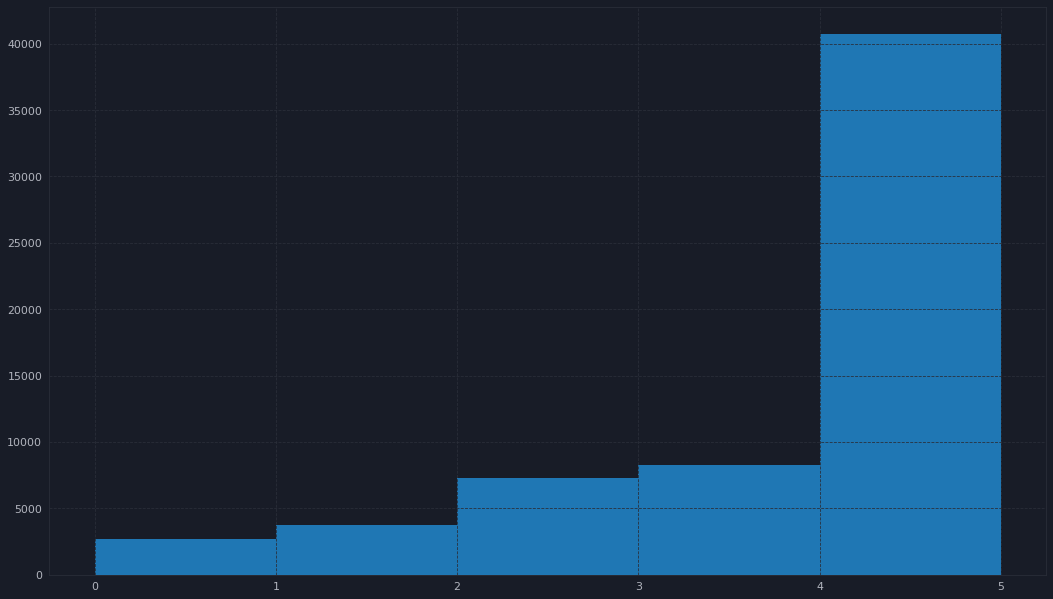

In [ ]:
hh_df["exp_class"].hist(bins=5)

# Город

In [ ]:
hh_df["Город"].apply(lambda x: x[:5]).value_counts()

Москв    23683
Санкт     6640
Красн     2246
Новос     1296
Казан     1237
         ...  
Новое        1
Софьи        1
Проле        1
Фанип        1
Малго        1
Name: Город, Length: 856, dtype: int64

In [ ]:
def split_city_on_classes(string):
  
  million_cities = ["Краснодар", "Екатеринбург", "Казань", "Нижний Новгород", "Челябинск",	"Самара", "Омск", "Ростов-на-Дону", "Уфа", "Красноярск", "Воронеж", "Пермь", "Волгоград"]

  if string.startswith("Москва"): 
    return 0
  elif string.startswith("Санкт-Петербург"):
    return 1
  elif string.startswith(tuple(million_cities)): 
    return 2
  else: 
    return 3

In [ ]:
hh_df["city_class"] = hh_df["Город"].apply(lambda x: split_city_on_classes(x))

In [ ]:
hh_df.city_class.value_counts()

0    23683
3    22111
2    10398
1     6640
Name: city_class, dtype: int64

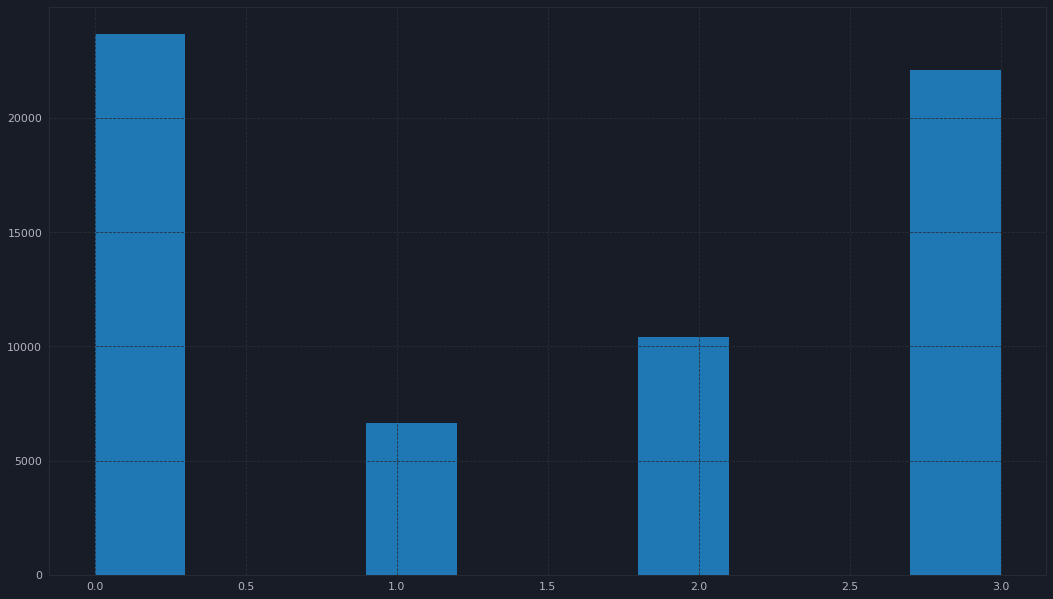

In [ ]:
hh_df.city_class.hist()

# Пол, возраст

In [ ]:
hh_df["Пол, возраст"]

0             Мужчина ,  29 лет , родился 16 мая 1989
1             Мужчина ,  38 лет , родился 25 мая 1980
2            Мужчина ,  35 лет , родился 14 июня 1983
3         Мужчина ,  33 года , родился 2 августа 1985
4        Мужчина ,  22 года , родился 1 сентября 1996
                             ...                     
62962     Мужчина ,  31 год , родился 11 октября 1987
62963     Мужчина ,  41 год , родился 13 декабря 1977
62964     Мужчина ,  26 лет , родился 2 сентября 1992
62965        Мужчина ,  35 лет , родился 23 июля 1983
62966    Мужчина ,  35 лет , родился 22 сентября 1983
Name: Пол, возраст, Length: 62832, dtype: object

In [ ]:
hh_df["Пол, возраст"].str[:10].value_counts()

Мужчина ,     50971
Женщина ,     11861
Name: Пол, возраст, dtype: int64

In [ ]:
def split_male_on_classes(string):
  
  if string.startswith("Женщина"): 
    return 0
  elif string.startswith("Мужчина"):
    return 1

In [ ]:
def get_age(string):

  current_year = 2021
  age = current_year - int(re.findall(r"\d{4}", string)[0])
  return age

In [ ]:
hh_df["age"] = hh_df["Пол, возраст"].apply(lambda x: get_age(x))

In [ ]:
hh_df["male"] = hh_df["Пол, возраст"].apply(lambda x: split_male_on_classes(x))

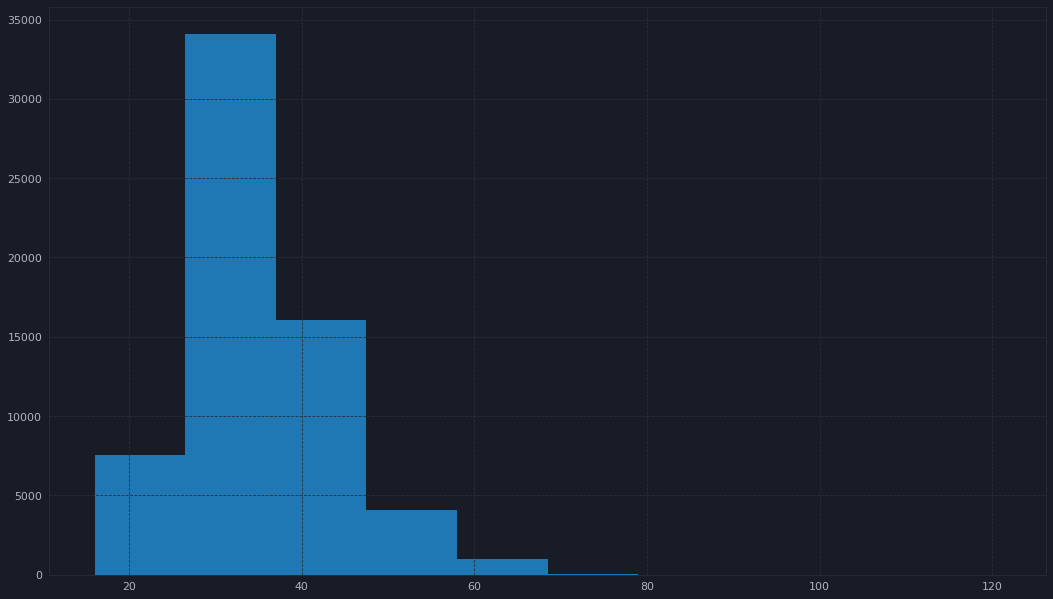

In [ ]:
hh_df["age"].hist()

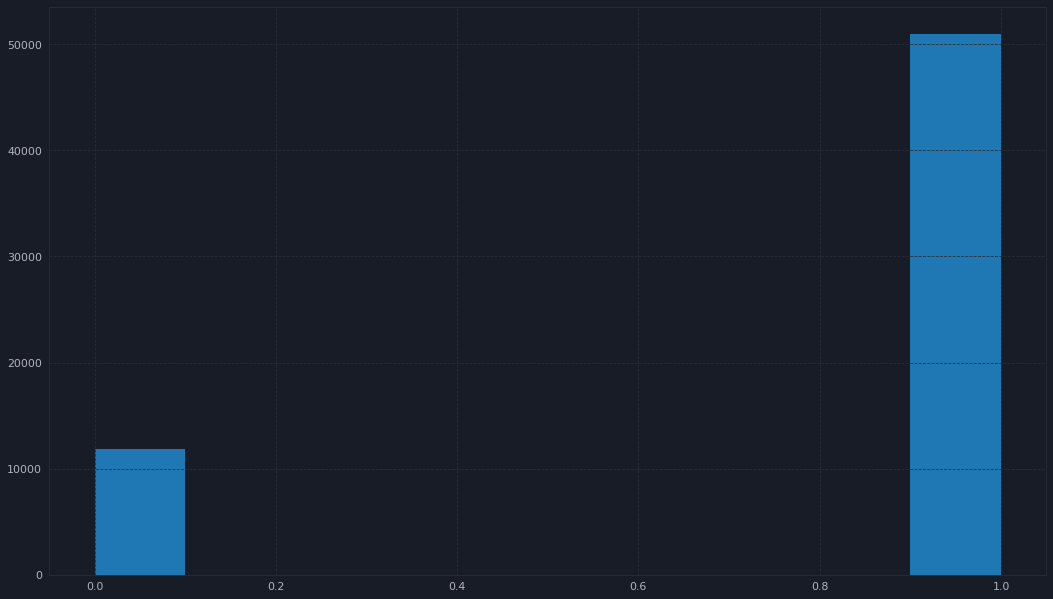

In [ ]:
hh_df["male"].hist()

In [ ]:
indexes_to_drop = hh_df[hh_df.age > 80].index 

In [ ]:
hh_df.drop(indexes_to_drop, inplace=True)

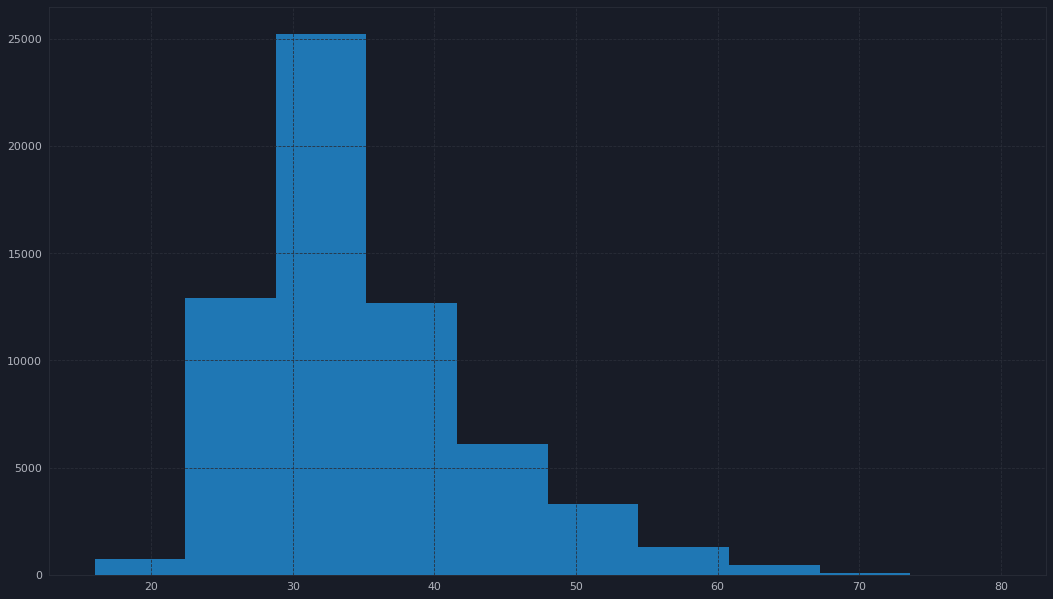

In [ ]:
hh_df["age"].hist()

In [ ]:
hh_df.isna().sum()

Пол, возраст                                0
зп_тыс_руб                                  0
Ищет работу на должность:                   0
Город                                       0
Занятость                                   0
График                                      0
Опыт (двойное нажатие для полной версии)    0
Последенее/нынешнее место работы            0
Последеняя/нынешняя должность               0
Образование и ВУЗ                           0
Обновление резюме                           0
Авто                                        0
exp_class                                   0
city_class                                  0
age                                         0
male                                        0
dtype: int64

#Занятость

In [ ]:
hh_df["Занятость"].unique()

array(['полная занятость', 'частичная занятость, полная занятость',
       'стажировка, частичная занятость, проектная работа',
       'частичная занятость, проектная работа, полная занятость',
       'стажировка, частичная занятость, проектная работа, полная занятость',
       'проектная работа, полная занятость',
       'стажировка, частичная занятость', 'частичная занятость',
       'проектная работа, частичная занятость, полная занятость',
       'частичная занятость, проектная работа',
       'стажировка, частичная занятость, полная занятость',
       'волонтерство, частичная занятость, проектная работа',
       'проектная работа',
       'проектная работа, стажировка, частичная занятость, полная занятость',
       'стажировка, полная занятость',
       'стажировка, волонтерство, частичная занятость, проектная работа, полная занятость',
       'проектная работа, волонтерство, частичная занятость, полная занятость',
       'стажировка, проектная работа, полная занятость',
       'п

In [ ]:
def split_employment_on_classes(string):

  employment_class = 0

  if ("стажировка" in string):
    employment_class += 1
  if ("волонтерство" in string):
    employment_class += 7
  if ("проектная работа" in string):
    employment_class += 13
  if ("частичная занятость" in string):
    employment_class += 23
  if ("полная занятость" in string):
    employment_class += 27
  
  return employment_class

In [ ]:
hh_df["employment_class"] = hh_df["Занятость"].apply(lambda x: split_employment_on_classes(x))

# График

In [ ]:
hh_df["График"].value_counts()

полный день                                                                     32000
гибкий график, полный день, сменный график, удаленная работа                     5720
гибкий график, полный день, удаленная работа                                     3806
гибкий график, полный день, сменный график                                       3088
полный день, сменный график                                                      2500
полный день, удаленная работа                                                    2336
гибкий график, полный день, сменный график, вахтовый метод, удаленная работа     2145
гибкий график, полный день                                                       2030
удаленная работа                                                                 1620
гибкий график, удаленная работа                                                  1017
удаленная работа, гибкий график, полный день, сменный график                      961
удаленная работа, гибкий график, полный день          

In [ ]:
def split_schedule_on_classes(string):

  schedule_class = 0

  if ("вахтовый метод" in string):
    schedule_class += 1
  if ("сменный график" in string):
    schedule_class += 7
  if ("гибкий график" in string):
    schedule_class += 13
  if ("полный день" in string):
    schedule_class += 23
  if ("удаленная работа" in string):
    schedule_class += 27
  
  return schedule_class

In [ ]:
hh_df["shedule_class"] = hh_df["График"].apply(lambda x: split_schedule_on_classes(x))

# Образование

In [ ]:
hh_df["Образование и ВУЗ"].str[:5].value_counts()

Высше    43617
Средн     8363
Неоко     5939
Образ     2270
Прогр      375
         ...  
BIM-м        1
UX/UI        1
стаже        1
ASP.N        1
CTO.         1
Name: Образование и ВУЗ, Length: 322, dtype: int64

In [ ]:
def split_education_on_classes(string):

  if "Высшее Higher education" in string:
    return 0
  elif "Высшее образование" in string:
    return 0
  elif "Среднее специальное" in string:
    return 1
  elif "Среднее образование" in string:
    return 2
  elif "Неоконченное высшее" in string:
    return 3
  
  else: return 4

In [ ]:
hh_df["education_class"] = hh_df["Образование и ВУЗ"].apply(lambda x: split_education_on_classes(x))

In [ ]:
hh_df.education_class.value_counts()

0    45848
1     8130
3     6226
2     2623
4        2
Name: education_class, dtype: int64

In [ ]:
hh_df[hh_df.education_class == 4]

,"Пол, возраст",зп_тыс_руб,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто,exp_class,city_class,age,male,employment_class,shedule_class,education_class
47436,"Мужчина , 24 года , родился 25 сентября 1994",40.0,Верстальщик,"Новокуйбышевск , готов к переезду (Москва, Сан...",полная занятость,"полный день, сменный график",Опыт работы 11 месяцев Июль 2018 — по настоящ...,ПрофСтрой,Мастер,Не указано,10.04.2019 07:10,Имеется собственный автомобиль,0,3,27,1,27,30,4
61361,"Женщина , 28 лет , родилась 12 августа 1990",150.0,Программист,"Москва , м. Преображенская площадь , готова к...",полная занятость,полный день,Опыт работы 12 лет 2 месяца Программист 150 0...,БДО,"Младший консультант SAP Договора, Казначейство.",Программист 150 000 руб. Информационные технол...,09.04.2019 23:33,Не указано,5,0,31,0,27,23,4


In [ ]:
hh_df.education_class[hh_df.education_class == 4] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
hh_df.education_class.value_counts()

0    45850
1     8130
3     6226
2     2623
Name: education_class, dtype: int64

#Авто

In [ ]:
hh_df["Авто"].value_counts()

Не указано                        45677
Имеется собственный автомобиль    17152
Name: Авто, dtype: int64

In [ ]:
hh_df["have_car"] = hh_df["Авто"].apply(lambda x: 1 if "Имеется" in x else 0)

In [ ]:
hh_df["have_car"].value_counts()

0    45677
1    17152
Name: have_car, dtype: int64

In [ ]:
hh_df.isna().sum()

Пол, возраст                                0
зп_тыс_руб                                  0
Ищет работу на должность:                   0
Город                                       0
Занятость                                   0
График                                      0
Опыт (двойное нажатие для полной версии)    0
Последенее/нынешнее место работы            0
Последеняя/нынешняя должность               0
Образование и ВУЗ                           0
Обновление резюме                           0
Авто                                        0
exp_class                                   0
city_class                                  0
age                                         0
male                                        0
employment_class                            0
shedule_class                               0
education_class                             0
have_car                                    0
dtype: int64

In [ ]:
hh_df.shape

(62829, 20)

#Текст по должности и опыту

In [ ]:
hh_df_to_model = hh_df.sample(frac=1)

In [ ]:
hh_df_to_model.head()

,"Пол, возраст",зп_тыс_руб,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто,exp_class,city_class,age,male,employment_class,shedule_class,education_class,have_car
3980,"Женщина , 45 лет , родилась 9 января 1974",45.0,Инженер-программист,"Калининград , хочу переехать , готова к редким...",полная занятость,полный день,Опыт работы 16 лет 5 месяцев Январь 2003 — по...,Eurocosmetics,Руководитель проекта,Неоконченное высшее образование 1997 Русско-Б...,21.04.2019 16:59,Не указано,5,3,47,0,27,23,3,0
15484,"Мужчина , 26 лет , родился 4 апреля 1993",60.0,Инженер-разработчик,"Москва , м. Выхино , не готов к переезду , го...","проектная работа, полная занятость","гибкий график, полный день, сменный график, уд...",Опыт работы 6 лет 8 месяцев Инженер-разработч...,HD-Studio (средство массовой информации),Фотокорреспондент / Представитель HD-Studio Do...,Высшее образование (Магистр) 2015 Южный федер...,28.01.2019 10:59,Не указано,4,0,28,1,40,70,0,0
43788,"Мужчина , 35 лет , родился 18 апреля 1984",150.0,Заместитель руководителя по информатизации,"Тюмень , не готов к переезду , готов к редким ...",полная занятость,"гибкий график, полный день",Опыт работы 12 лет 5 месяцев Июль 2018 — по н...,БУ ХМАО-Югры «Центр спортивной подготовки сбор...,Начальник Управления по информационным ресурсам,Высшее образование 2007 Российский университет...,15.04.2019 12:55,Имеется собственный автомобиль,5,3,37,1,27,36,0,1
33843,"Мужчина , 33 года , родился 7 апреля 1986",45.0,Монтажник,"Санкт-Петербург , м. Садовая , готов к переез...","стажировка, волонтерство, частичная занятость,...","гибкий график, полный день, сменный график, ва...",Опыт работы 11 лет 5 месяцев Апрель 2018 — по...,Везёт,Водитель,Среднее специальное образование 2004 ПУ 26 Дне...,13.04.2019 10:05,Не указано,5,1,35,1,71,71,1,0
58855,"Мужчина , 37 лет , родился 12 августа 1981",100.0,Руководитель ИТ-отдела,"Москва , м. Красногвардейская , не готов к пе...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Руководитель ИТ...,"ГКУК г. Москвы ""Дирекция культурных центров""",Руководитель отдела информатизации,Высшее образование 2011 Институт информационны...,27.04.2019 20:49,Имеется собственный автомобиль,5,0,40,1,27,23,0,1


In [ ]:
values = hh_df_to_model.iloc[:, 0:11].values

In [ ]:
def get_text_job_data(values):

  text_job_data = []
  
  for val in values:
    current_text = ""
    if (type(val[2]) == str):
      current_text += val[2]
    if (type(val[8]) == str):
      current_text += " " + val[8]

    text_job_data.append(current_text)
  
  text_job_data = np.array(text_job_data)
  
  return text_job_data

In [ ]:
text_job_data = get_text_job_data(values)
text_job_data.shape

(62829,)

In [ ]:
def get_text_exp_data(values):

  text_exp_data = []
  
  for val in values:
    current_text = ""
    if (type(val[6]) == str):
      current_text += val[6]

    text_exp_data.append(current_text)
  
  text_exp_data = np.array(text_exp_data)
  
  return text_exp_data

In [ ]:
text_exp_data = get_text_exp_data(values)
text_exp_data.shape

(62829,)

# train_test

In [ ]:
X = hh_df_to_model.iloc[:, 12:].values
y = hh_df_to_model["зп_тыс_руб"].values

print(y.mean(), y.std())
print(X.shape, y.shape)

76.85304779639976 63.61388992577989
(62829, 8) (62829,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((50263, 8), (12566, 8), (50263,), (12566,))

In [ ]:
y_scaler = StandardScaler()
y_scaler.fit(y_train.reshape(-1, 1))
y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1))

print(y_train_scaled.shape)
print(y_train_scaled.mean(), y_train_scaled.std())

(50263, 1)
-1.1659075688242695e-16 1.0


In [ ]:
x_scaler = StandardScaler()
x_scaler.fit(X_train)
X_train_scaled = x_scaler.transform(X_train)
print(X_train_scaled.shape)
print(X_train_scaled.T[4].mean(), X_train_scaled.T[4].std())

(50263, 8)
1.2793529551815265e-17 1.000000000000225


In [ ]:
max_words_count = 5000

tokenizer = Tokenizer(max_words_count, oov_token="unknown")
tokenizer.fit_on_texts(text_job_data)
print(len(tokenizer.word_index.values()))
text_job_word_sequence = tokenizer.texts_to_sequences(text_job_data)

9991


In [ ]:
def get_words_count(word_sequence):

  text_len = []

  for i in word_sequence:
    text_len.append(len(i))

  plt.hist(text_len, bins=100)
  plt.show()

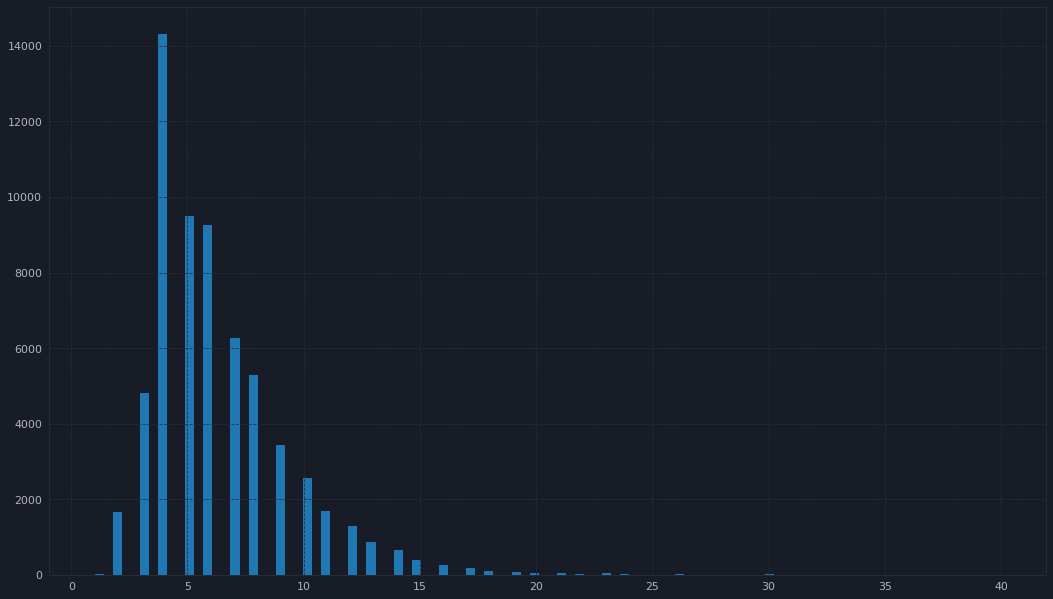

In [ ]:
get_words_count(text_job_word_sequence)

In [ ]:
text_job_word_sequence = pad_sequences(text_job_word_sequence, 16)
text_job_word_sequence.shape

(62829, 16)

In [ ]:
tokenizer = Tokenizer(max_words_count, oov_token="unknown")
tokenizer.fit_on_texts(text_exp_data)
text_exp_word_sequence = tokenizer.texts_to_sequences(text_exp_data)

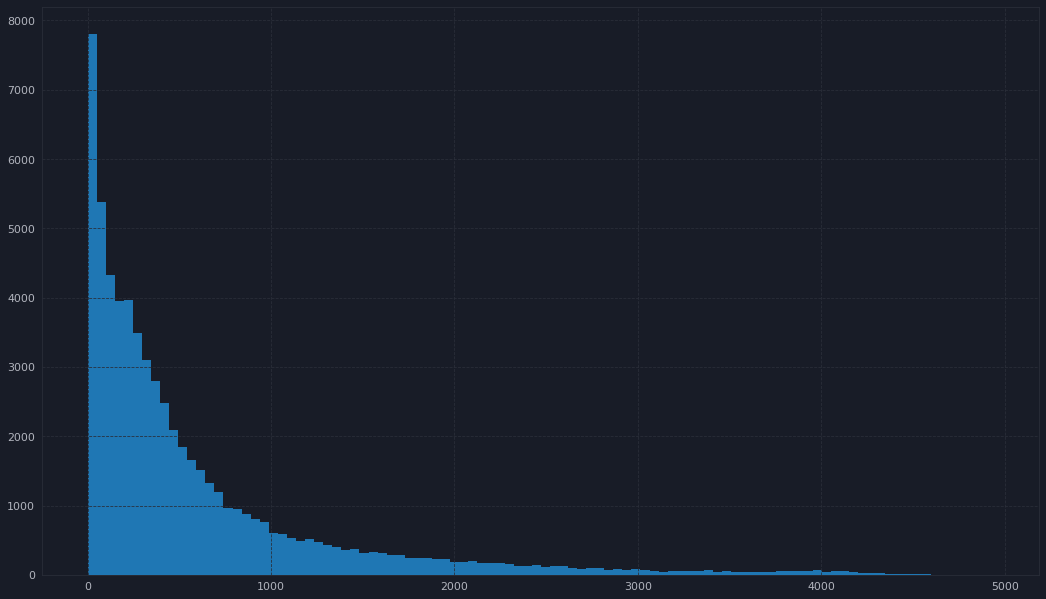

In [ ]:
get_words_count(text_exp_word_sequence)

In [ ]:
text_exp_word_sequence = pad_sequences(text_exp_word_sequence, 1200)
text_exp_word_sequence.shape

(62829, 1200)

# Error plot

In [ ]:
def get_error_plot(history):

  plt.plot(history.history["mae"], 
          label="MAE on train")
  plt.plot(history.history["val_mae"], 
          label="MAE on valid")
  plt.xlabel("Epoch")
  plt.ylabel("MAE")
  plt.legend()
  plt.show()

In [ ]:
def get_right_predict_plot(X_test, y_test):

  X_test_scaled = x_scaler.transform(X_test)
  prediction = model.predict([X_test_scaled, text_job_word_sequence[50263:], text_exp_word_sequence[50263:]])
  y_pred = y_scaler.inverse_transform(prediction).flatten()
  print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

  plt.scatter(y_test, y_pred)
  plt.xlabel("Right_values")
  plt.ylabel("Predictions")
  plt.axis('equal')
  
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.plot([-1000, 1000], [-1000, 1000])
  plt.show()

#Модель

In [ ]:
input1 = Input((X_train_scaled.shape[1],))
input2 = Input((text_job_word_sequence.shape[1],))
input3 = Input((text_exp_word_sequence.shape[1],))

x1 = Dense(16, activation="elu")(input1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(8, activation = "elu")(x1)

x2 = Embedding(max_words_count, 50)(input2)
x2 = Conv1D(50, 5, padding="same", activation="elu")(x2)
x2 = MaxPool1D()(x2)
x2 = BatchNormalization()(x2)
x2 = Conv1D(100, 5, padding="same", activation="elu")(x2)
x2 = GlobalMaxPooling1D()(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)
x2 = Dense(64, activation = "elu")(x2)

x3 = Embedding(max_words_count, 50)(input3)
x3 = Conv1D(256, 5, padding="same", activation="elu")(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPool1D()(x3)
x3 = Conv1D(512, 5, padding="same", activation="elu")(x3)
x3 = GlobalMaxPooling1D()(x3)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.5)(x3)
x3 = Dense(256, activation = "elu")(x3)

x = concatenate([x1, x2, x3])

x = Dense(128, activation="linear")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="linear")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(1, activation="linear")(x)

model = Model((input1, input2, input3), x)

In [ ]:
model.summary()

In [ ]:
utils.plot_model(model, show_layer_names=False)

In [ ]:
def get_batch_size(shape):

  batches = []

  for i in range(2, 1000):
    if shape % i == 0:
      batches.append(i)
  
  if batches:
    return batches
  else:
    print("Didn't find integer divisors")

In [ ]:
print(get_batch_size(43000))

[2, 4, 5, 8, 10, 20, 25, 40, 43, 50, 86, 100, 125, 172, 200, 215, 250, 344, 430, 500, 860]


In [ ]:
epochs, val_loss = 1, 1
checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/models/classf_car_epoch-{epochs:02d}-val_loss-{val_loss:.2f}.hdf5", monitor="val_loss", verbose=1, save_best_only=True, mode="auto", save_freq="epoch")
early_stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, verbose=1, mode="auto", baseline=None, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1, mode="auto", min_delta=0, cooldown=0, min_lr=0.00001)

Epoch 1/100
344/344 [==============================] - ETA: 0s - loss: 1.1454 - mae: 0.7518
Epoch 00001: val_loss improved from inf to 1.75133, saving model to /content/drive/MyDrive/models/classf_car_epoch-01-val_loss-1.00.hdf5
344/344 [==============================] - 37s 101ms/step - loss: 1.1454 - mae: 0.7518 - val_loss: 1.7513 - val_mae: 0.9886 - lr: 0.0010
Epoch 2/100
344/344 [==============================] - ETA: 0s - loss: 0.4956 - mae: 0.4772
Epoch 00002: val_loss improved from 1.75133 to 0.71573, saving model to /content/drive/MyDrive/models/classf_car_epoch-01-val_loss-1.00.hdf5
344/344 [==============================] - 31s 89ms/step - loss: 0.4956 - mae: 0.4772 - val_loss: 0.7157 - val_mae: 0.5022 - lr: 0.0010
Epoch 3/100
344/344 [==============================] - ETA: 0s - loss: 0.3202 - mae: 0.3722
Epoch 00003: val_loss improved from 0.71573 to 0.29977, saving model to /content/drive/MyDrive/models/classf_car_epoch-01-val_loss-1.00.hdf5
344/344 [=======================

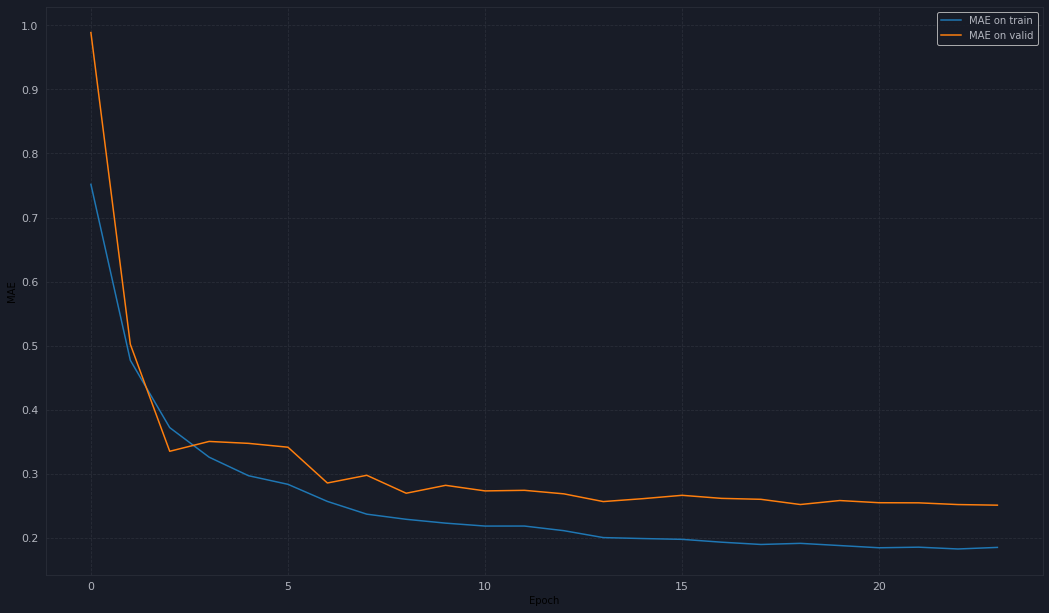

MAE: 15.88875841933376


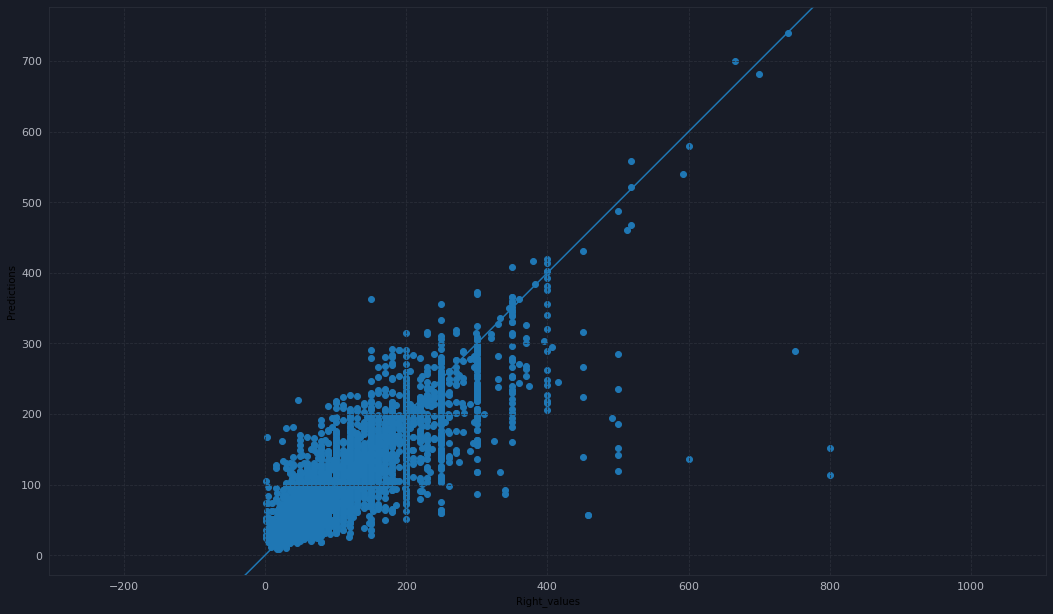

In [ ]:
model.compile(optimizer=Adam(0.001), loss="mse", metrics="mae")

history = model.fit([X_train_scaled[:43000], text_job_word_sequence[:43000], text_exp_word_sequence[:43000]], 
                    y_train_scaled[:43000], 
                    epochs=100, 
                    validation_data=([X_train_scaled[43000:50263], text_job_word_sequence[43000:50263], text_exp_word_sequence[43000:50263]], 
                    y_train_scaled[43000:50263]), 
                    batch_size=125,
                    verbose=1,
                    callbacks=[checkpoint, early_stop, reduce_lr])

get_error_plot(history)
get_right_predict_plot(X_test, y_test)

In [ ]:
# Дальше можно посмотреть на выбросы сделать выводы, поработать над данными и архитектурой. С текстом в данном случае BOW вероятно будет работать лучше.

#Callback

In [ ]:
def on_train_begin(logs):
  
  global losses
  global val_losses
  global start
  global best_loss

  losses = []
  val_losses = []
  
  start = datetime.datetime.now()
  print("Start time:", start)
  best_loss = sys.maxsize

In [ ]:
def on_epoch_begin(epoch, logs):

  global epoch_start

  epoch_start = datetime.datetime.now()
  print("Learning step:", round(K.eval(model.optimizer.lr), 5))

In [ ]:
def on_epoch_end(epoch, logs):
  
  clear_output(wait=True)
  
  prediction = model.predict([X_train_scaled[43000:50263], text_job_word_sequence[43000:50263], text_exp_word_sequence[43000:50263]])
  prediction_inverse = y_scaler.inverse_transform(prediction).flatten()
  y_inverse = y_scaler.inverse_transform(y_train_scaled[43000:50263]).flatten()
  delta = prediction_inverse - y_inverse
  abs_delta = abs(delta)
  print("Epoch: ", epoch, ", ", " MAE: ", round(sum(abs_delta) / (len(abs_delta)), 3), sep="")

  losses.append(list(logs.values())[0])
  val_losses.append(list(logs.values())[1])
  
  if (len(losses) > 1):
    n = np.arange(0, len(losses))
    plt.figure()
    plt.plot(n, losses, label="Loss on train_data")
    plt.plot(n, val_losses, label="Loss on valid_data")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

  y_t_scaled = y_train_scaled[43000:50263]
  plt.scatter(y_t_scaled, prediction)
  plt.xlabel("Right values")
  plt.ylabel("Prediction")
  plt.axis("equal")
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.plot([-1000, 5000],[-1000, 5000])
  plt.show()
  
  delta_scaled = prediction - y_t_scaled
  abs_delta_scaled = abs(delta_scaled)
  plt.hist(abs_delta_scaled.flatten(), bins=np.linspace(0,0.5,25), ec="black")
  plt.xlabel("AE")
  plt.ylabel("Count")
  plt.show()

  cur_time = datetime.datetime.now()
  train_time = cur_time - start
  epoch_time = cur_time - epoch_start
  avg_time = (train_time / (epoch + 1))
  left_epochs = (epochs - (epoch + 1))
  left_time = avg_time * left_epochs
  print("Time for an epoch: ",epoch_time,", ", "total training time: ", train_time, " ,", "time left until the end: ", left_time,sep="")

  if epoch > 3:

    temp_losses = val_losses[epoch - 3]

    if (val_losses[epoch - 3] > val_losses[epoch - 2] < val_losses[epoch - 1] > val_losses[epoch]) and (np.mean(temp_losses) < np.min(temp_losses) + 0.1):
        model.optimizer.lr.assign(K.eval(model.optimizer.lr) * 0.5)
        print("Learning step was changed due to SAW")
        print("New learning step:", round(K.eval(model.optimizer.lr), 10))

    if np.mean(temp_losses) < np.min(temp_losses) + 0.1:
      model.optimizer.lr.assign(K.eval(model.optimizer.lr) * 3)
      print("Learning step was changed due to PLATO")
      print("New learning step:", round(K.eval(model.optimizer.lr), 10))

  best_loss = val_losses[0]
  if (list(logs.values())[1] < best_loss):
    model.save_weights("best_loss.h5")
    best_loss = list(logs.values())[1]
    print("Best weights found, values ​​have been updated")

In [ ]:
clbk = LambdaCallback(on_train_begin=on_train_begin, on_epoch_begin=on_epoch_begin, on_epoch_end=on_epoch_end)